# Basic Data Manipulation



In [1]:
# Import Dependencies and Define Global Variables
import pandas_datareader.data as web
import pandas as pd
import numpy as np
# configure ldconf or environment variable
# export LD_LIBRARY_PATH=/usr/local/lib:$LD_LIBRARY_PATH
from talib import RSI, BBANDS, EMA
import matplotlib.pyplot as plt

start = '2009-08-14'
end = '2021-02-19'
symbol = 'VNM'
max_holding = 100

In [5]:
# Download Data

# set IEX_API_KEY= before using iex
# To suppress potential SSL error
# export CURL_CA_BUNDLE=""
vnm = web.DataReader(name=symbol, data_source='iex', start=start, end=end)
# set QUANDL_API_KEY before using quandl
# caveat: didn't find US ETF from quandl
# price = web.DataReader(name=symbol, data_source='quandl', start=start, end=end)
%store vnm

Stored 'vnm' (DataFrame)


In [2]:
# Restore fetched data to avoid calling API too much
%store -r vnm
vnm.tail(1)


,open,high,low,close,volume
date,,,,,
2021-02-19,18.44,18.45,18.2,18.39,428126


In [3]:
vnm.index = pd.to_datetime(vnm.index)
close = vnm['close']

# Getting all weekdays between 01/01/2000 and 12/31/2016
all_weekdays = pd.date_range(start=start, end=end, freq='B')

# How do we align the existing prices in adj_close with our new set of dates?
# All we need to do is reindex close using all_weekdays as the new index
close = close.reindex(all_weekdays)

# Reindexing will insert missing values (NaN) for the dates that were not present
# in the original set. To cope with this, we can fill the missing by replacing them
# with the latest available price for each instrument.
close = close.fillna(method='ffill')

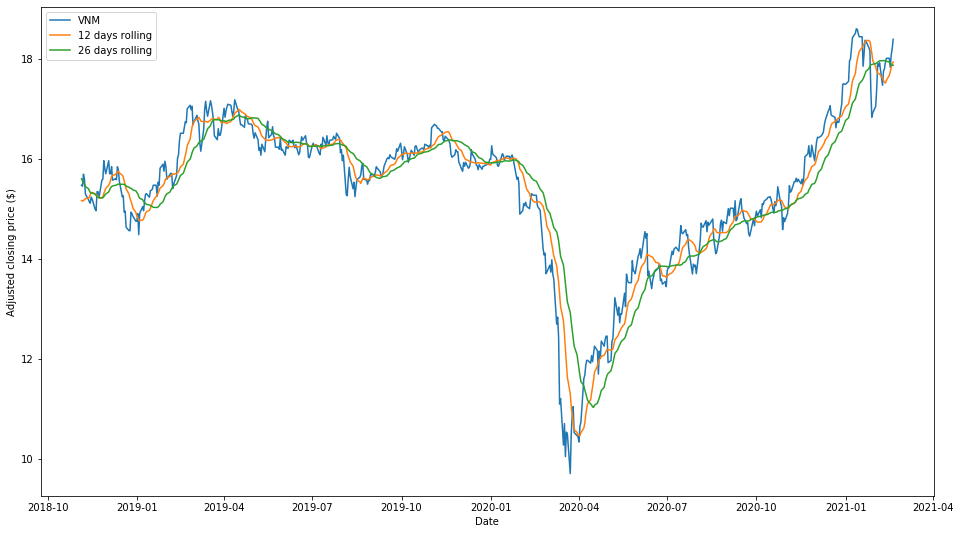

In [4]:
lookback = 600
# Calculate the 12 and 26 days moving averages of the closing prices
short_rolling = close.rolling(window=12).mean()
long_rolling = close.rolling(window=26).mean()

# Plot everything by leveraging the very powerful matplotlib package
fig, ax = plt.subplots(figsize=(16,9))

ax.plot(close.index[-lookback:], close[-lookback:], label='VNM')
ax.plot(short_rolling.index[-lookback:], short_rolling[-lookback:], label='12 days rolling')
ax.plot(long_rolling.index[-lookback:], long_rolling[-lookback:], label='26 days rolling')

ax.set_xlabel('Date')
ax.set_ylabel('Adjusted closing price ($)')
ax.legend()

## Calculate Returns and Some Indicators

In [5]:
# Calculate return, log return and vol, rsi
close.dropna()
close.describe()
daily_return = close.pct_change(1).rename('dRet')
dMeanRet = daily_return.mean()
print(dMeanRet)
log_return = np.log(close).diff().rename('logRet')
aVol = log_return.rolling(21).std().rename('vol')*(252**0.5)
rsi = RSI(close, timeperiod=14).rename('rsi')
vnm_details = pd.concat([close, log_return, daily_return, aVol, rsi], axis=1)
vnm_details.tail(1)

1.2027519791481863e-05


,close,logRet,dRet,vol,rsi
2021-02-19,18.39,0.010385,0.01044,0.271096,61.451581


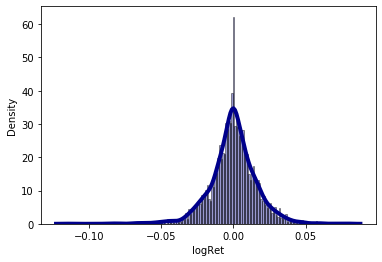

In [6]:
# Plot density and histogram
import seaborn as sns
sns.distplot(log_return, hist=True, kde=True, 
             bins=int(180), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

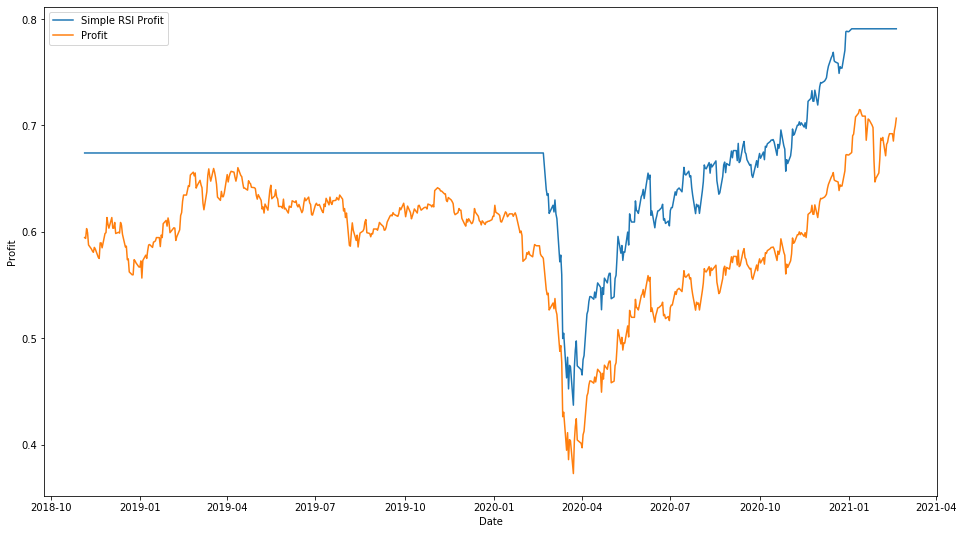

In [23]:
holdings = pd.DataFrame(index=vnm_details.index, data={'Holdings': np.array([np.nan] * vnm_details.index.shape[0])})
holdings.loc[((vnm_details['rsi'] < 20)), 'Holdings'] = 1
holdings.loc[((vnm_details['rsi'] > 80)), 'Holdings'] = 0
holdings.ffill(inplace=True)
holdings.fillna(0, inplace=True)

holdings['Order'] = holdings.diff()
holdings.dropna(inplace=True)
rsiprofit = (holdings['Holdings'].multiply(daily_return)+1).cumprod()
profit = (daily_return+1).cumprod()

lookback = 600
# Plot everything by leveraging the very powerful matplotlib package
fig, ax = plt.subplots(figsize=(16,9))

ax.plot(rsiprofit.index[-lookback:], rsiprofit[-lookback:], label='Simple RSI Profit')
ax.plot(profit.index[-lookback:], profit[-lookback:], label='Profit')

ax.set_xlabel('Date')
ax.set_ylabel('Profit')
ax.legend()
